In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import json
import warnings
from datetime import datetime
from cycler import cycler
from datetime import datetime
import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")
import matplotlib as mpl
mpl.rcParams["lines.linewidth"] = 2
# plt.style.use('ggplot')
sns.set_style("ticks")



plt.rcParams.update(
    {
        "axes.titlesize": 24,  # Title font size
        "axes.labelpad": 10,  # Padding for the x and y labels
        "axes.labelcolor": "dimgray",
        "xtick.labelsize": 16,  # Font size for the x tick labels
        "ytick.labelsize": 16,  # Font size for the y tick labels
        "axes.labelsize": 20,  # Font size for the x and y axis labels
        "font.family": "serif",  # Set the font family to Arial
        "grid.linestyle": "--",  # Set the style of the gridlines
        "grid.linewidth": 0.5,  # Set the width of the gridlines
        "grid.color": "gray",  # Set the color of the gridlines
        "axes.grid": True,  # Enable the grid
        "axes.grid.which": "both",  # Apply the grid to both major and minor ticks
        "xtick.direction": "in",  # Set the direction of the x tick marks
        "ytick.direction": "in",  # Set the direction of the y tick marks
        "xtick.major.size": 6,  # Set the length of the major x tick marks
        "xtick.major.width": 2,  # Set the width of the major x tick marks
        "ytick.major.size": 6,  # Set the length of the major y tick marks
        "ytick.major.width": 2,  # Set the width of the major y tick marks
        "xtick.color": "gray",  # Color of x tick labels and tick lines
        "ytick.color": "gray",  # Color of y tick labels and tick lines
    }
)


In [5]:
def build_combined_df(dems):
    combined_df = pd.DataFrame()
    for dem_year in dems:
        temp_df = pd.read_csv(
            f"Results/DuneFeatures_Width_Height_Slope/Data/duneCharacteristics_{dem_year.replace(' ', '_')}.csv"
        )
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)
    combined_df.rename(
        columns={
            "islandWidth": "Island Width (m)",
            "alongshore": "Alongshore Distances (m)",
            "maxElevation": "Max Elevation (m)",
            "primaryDuneHeight": "Primary Dune Height (m)",
            "maxDuneSlope": "Max Dune Slope",
        },
        inplace=True,
    )
    combined_df["DEM"] = combined_df["DEM"].map(dem_date_map)

    return combined_df


In [6]:
dems = (
    "DEM 2001",
    "DEM 2002",
    "DEM 2009",
    "DEM 2018",
    "DEM 2018_19_post_harvey",
)


dem_date_map = {
    "DEM 2001": "10/13/01",
    "DEM 2002": "9/18/02",
    "DEM 2009": "3/15/09",
    "DEM 2018": "2/16/18",
    "DEM 2018_19_post_harvey": "2/9/19",
}

for dem, date_str in dem_date_map.items():
    date_obj = datetime.strptime(date_str, "%m/%d/%y")
    dem_date_map[dem] = date_obj.strftime("%b %Y")

dem_date_map


island_df = build_combined_df(dems)


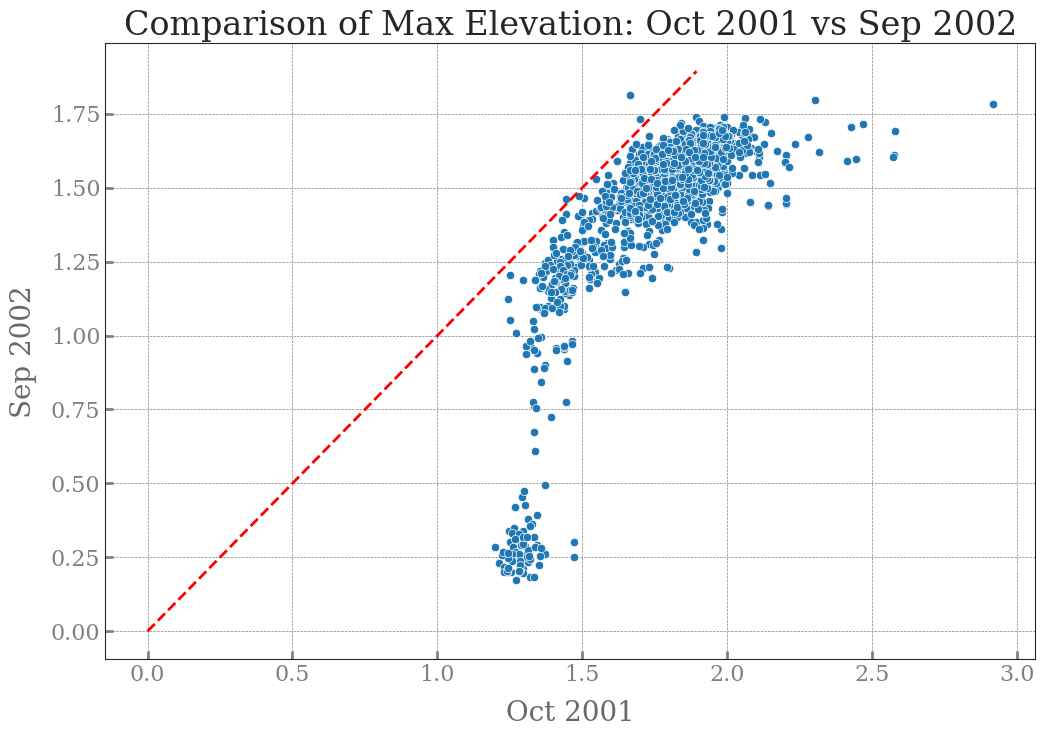

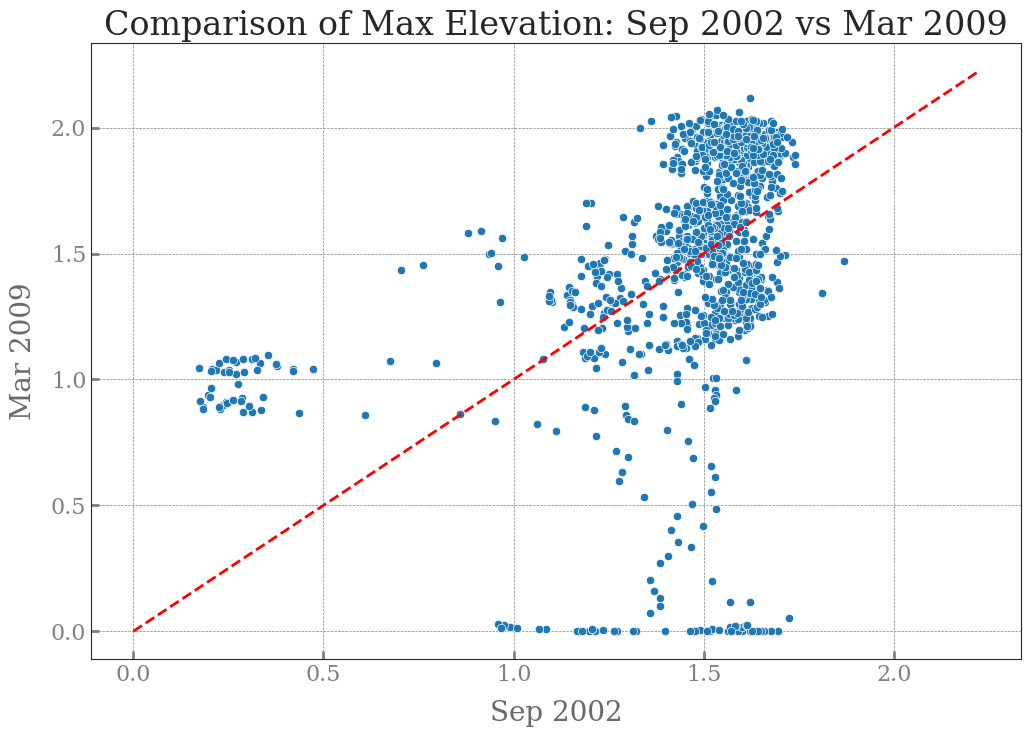

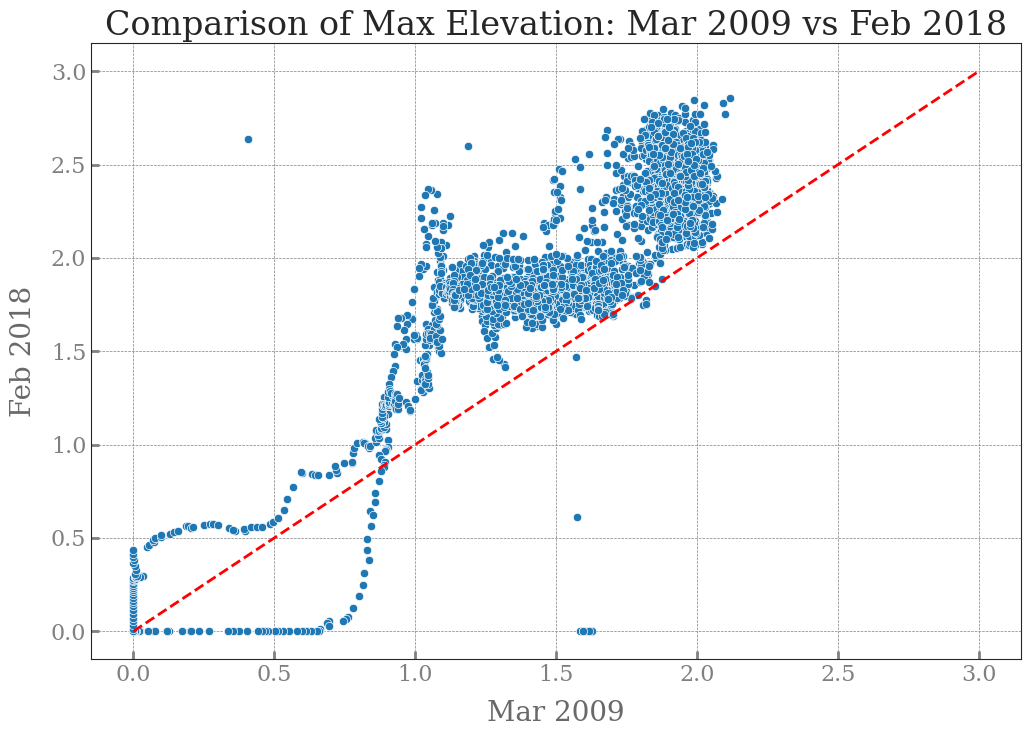

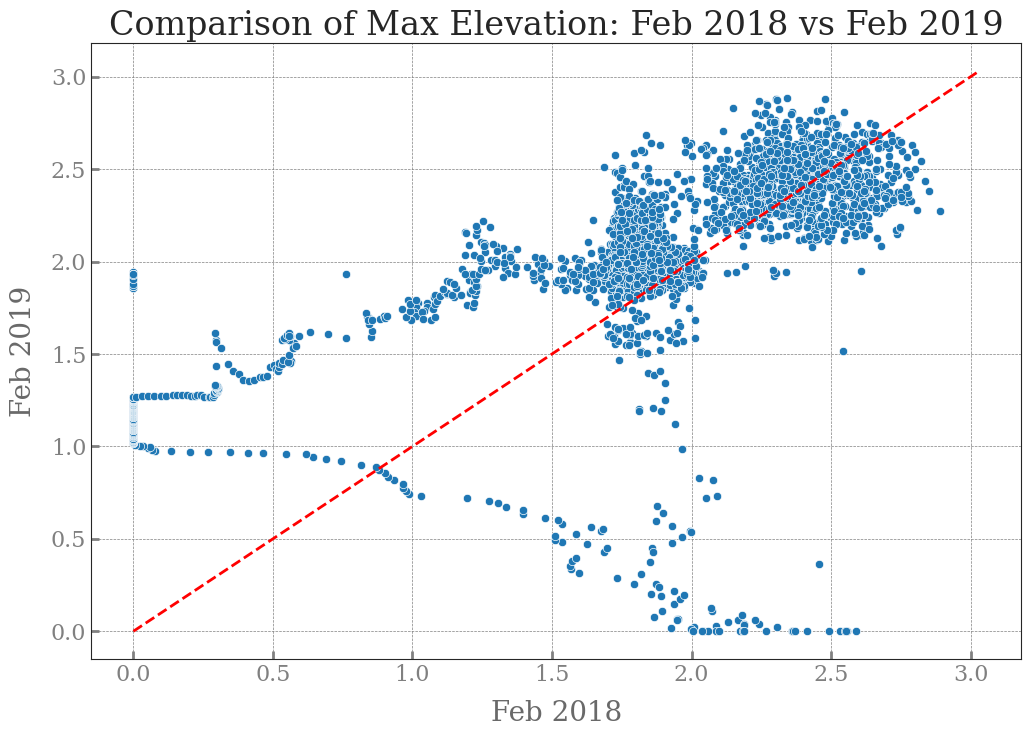

In [11]:

# Provided DEM dates
dem_dates = {
    "Oct 2001": "10/13/01",
    "Sep 2002": "9/18/02",
    "Mar 2009": "3/15/09",
    "Feb 2018": "2/16/18",
    "Feb 2019": "2/9/19",
}

for key in dem_dates:
    dem_dates[key] = datetime.strptime(dem_dates[key], "%m/%d/%y")

sorted_dem_years = sorted(dem_dates, key=dem_dates.get)

# Correct column names from island_df
alongshore_col = "Alongshore Distances (m)"
max_elevation_col = "Max Elevation (m)"

# Create directory if it doesn't exist
output_dir = 'May 17'
os.makedirs(output_dir, exist_ok=True)

# Iterate over DEM pairs for interpolation and plotting
for i in range(len(sorted_dem_years) - 1):
    year1 = sorted_dem_years[i]
    year2 = sorted_dem_years[i + 1]

    df_year1 = island_df[island_df["DEM"] == year1][[alongshore_col, max_elevation_col]]
    df_year2 = island_df[island_df["DEM"] == year2][[alongshore_col, max_elevation_col]]

    valid_mask = df_year1[alongshore_col].apply(
        lambda x: df_year2[alongshore_col][df_year2[alongshore_col] < x].any()
        and df_year2[alongshore_col][df_year2[alongshore_col] > x].any()
    )
    valid_alongshoreDistances = df_year1[alongshore_col][valid_mask]

    interpolated_heights_valid = np.interp(
        valid_alongshoreDistances,
        df_year2[alongshore_col],
        df_year2[max_elevation_col],
    )

    # Plotting the comparison of max elevations
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x=df_year1[max_elevation_col][valid_mask].values,
        y=interpolated_heights_valid
    )
    ylim = plt.gca().get_ylim()[1]
    plt.plot([0, ylim], [0, ylim], color='red', linestyle='--')
    plt.title(f"Comparison of Max Elevation: {year1} vs {year2}")
    plt.xlabel(f"{year1}")
    plt.ylabel(f"{year2}")
    plt.savefig(os.path.join(output_dir, f"Comparison_{year1}_vs_{year2}.png"), dpi=600)
    plt.show()
